# Milestone M1d - MR simulator and fitting

We will compare accuracy and runtime with [Sycomore](https://sycomore.readthedocs.io/en/latest/epg/index.html) and [mri-sim-py](https://github.com/utcsilab/mri-sim-py). We will simulate a Fast Spin Echo acquisition for Myelin Water Fraction mapping (with and without exchange between myelin water and free water).

First, we define some utilities to plot signals:

In [1]:
%matplotlib inline
        
import numpy as np
import matplotlib.pyplot as plt

# plotting
def display_signal(input, legend=None, symbol='-', color=None):
    if color is not None:
        plt.gca().set_prop_cycle(plt.cycler("color", color))
    plt.plot(abs(input), symbol)
    plt.xlim([0, len(input)])
    plt.xlabel("Echo index")
    plt.ylabel("signal magnitude [a.u.]")
    if legend is not None:
        plt.legend(legend)
    plt.tight_layout()

## Reference implementation

Reference implementations of using [mri-sim-py](mri-sim-py](https://github.com/utcsilab/mri-sim-py) (Pytorch backend, GPU-accelerated, no exchange, magnetization transfer or flow) and [Sycomore](https://sycomore.readthedocs.io/en/latest/epg/index.html) (C++ backend, CPU-only, not parallelized across multiple atoms, accounts for exchange, magnetization transfer and flow).

In [2]:
# load ground truth EPG-X data
import scipy

ground_truth = scipy.io.loadmat("epgxsignal.mat")
sig0noex = ground_truth["s0"].squeeze() 
sig0ex = ground_truth["s"].squeeze() 

## Validation

In [3]:
import deepmr

# parameters
flip = 50 * [180.0]
phases = 50 * [90.0]
ESP = 5.0

T1 = 1000.0 # [500.0, 833.0, 2569.0]
T2 = 100.0  # 

T1b = 500.0 # ms 
T2b = 20.0 # ms 

f = 0.2
k = 10.0 # Hz  

# computation
signoex = deepmr.bloch.fse(flip, phases, ESP, T1, T2, T1bm=T1b, T2bm=T2b, kbm=0.0, weight_bm=f)
sigex = deepmr.bloch.fse(flip, phases, ESP, T1, T2, T1bm=T1b, T2bm=T2b, kbm=k, weight_bm=f)

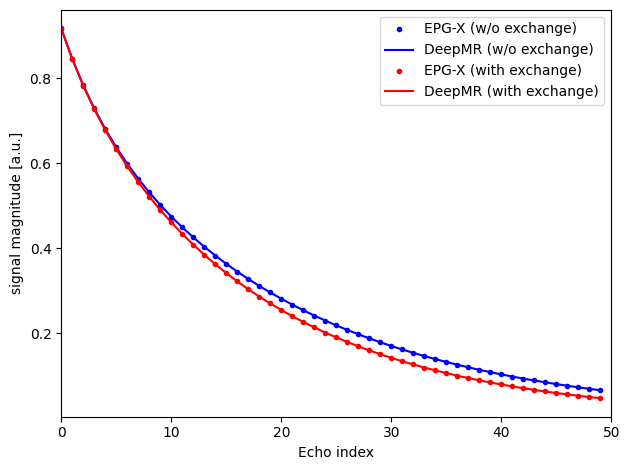

In [4]:
legend = ["EPG-X (w/o exchange)", "DeepMR (w/o exchange)", "EPG-X (with exchange)", "DeepMR (with exchange)"]
display_signal(sig0noex.T, color=["b"], symbol='.'),
display_signal(signoex.T, color=["b"], symbol='-'),
display_signal(sig0ex.T, color=["r"], symbol='.'), 
display_signal(sigex.T, color=["r"], symbol='-', legend=legend)

## Benchmark